# Comparing ISO data over time

The following notebook loads two time periods of ISO data from GridStatus and compares them. 


* Is it possible to track a single project through time consistently through one ISO dataset?
* Where has been the most activity and where have projects progressed the most? What kinds of projects have those been?
* Looking at percent changes and mapping activity by county chloropleth to make visualizing changes simple

draft draft

## Part 1: Can IDs be used to compare projects over time?

### Loading the data

In [89]:
import pandas as pd
import geopandas as gpd
import pyarrow
import fastparquet
from pathlib import Path
import os
import matplotlib
pd.options.mode.chained_assignment = None

In [2]:
home_directory = os.path.dirname(os.getcwd())
data_folder = os.path.join(home_directory, "reports/")

In [3]:
# Configure parameters - set baseline and end date and input file names
baseline_date = "2023-07-09"
new_date = "2023-12-17"

baseline_path = os.path.join(data_folder, "iso_queues_ex_spp_isone_july9.parquet")
new_path = os.path.join(data_folder, "iso_queues_december17.parquet")

In [4]:
baseline_dataset = pd.read_parquet(baseline_path)
new_dataset = pd.read_parquet(new_path)

### Comparing project IDs across timestamps

In [5]:
# Confirm that each dataset has the same primary key
print(baseline_dataset.set_index(["queue_id", "iso_region"]).index.is_unique)
print(new_dataset.set_index(["queue_id", "iso_region"]).index.is_unique)

True
True


In [6]:
# Add date as column to enable match between ISO records
baseline_dataset['record_date'] = baseline_date
new_dataset['record_date'] = new_date

In [7]:
# NYISO has an inconsistent use of leading zeros in queue IDs between dates.
# Standardize this.
m = (baseline_dataset['queue_id'].str.isnumeric())&(baseline_dataset.iso_region=="nyiso")
baseline_dataset.loc[m, 'queue_id'] = baseline_dataset.loc[m, 'queue_id'].str.lstrip('0')


In [8]:
baseline_dataset[["queue_id", "iso_region"]]

,queue_id,iso_region
0,J1204,miso
1,J1216,miso
2,J1221,miso
3,J1262,miso
4,J1295,miso
...,...,...
6365,1565,nyiso
6366,1566,nyiso
6367,1569,nyiso
6368,1573,nyiso


In [9]:
# Merge datasets
merged_data = baseline_dataset.merge(new_dataset, how = "outer", indicator=True, on=['queue_id', 'iso_region'])

In [10]:
# At a high level, how well did this work?
# Right only is the new dataset, while left_only is the baseline dataset
merged_data._merge.value_counts()

_merge
both          5880
right_only    1289
left_only      490
Name: count, dtype: int64

In [11]:
baseline_dataset.loc[0]

project_id                                              0
actual_completion_date                                NaT
capacity_mw                                         199.3
county                                  Cumberland County
resource                                            Solar
interconnecting_entity                               <NA>
point_of_interconnection      Casey West 345kV Substation
project_name                                         <NA>
proposed_completion_date                              NaT
queue_date                            2019-04-26 04:00:00
queue_id                                            J1204
state                                                  IL
queue_status                                       active
summer_capacity_mw                                  199.3
transmission_owner                        Ameren Illinois
winter_capacity_mw                                  199.3
withdrawal_comment                                   <NA>
withdrawn_date

In [12]:
# Do the same IDs likely refer to the same projects over time?
state_change = merged_data[(merged_data._merge == "both") & (merged_data.state_x != merged_data.state_y)]
queue_change = merged_data[(merged_data._merge == "both") & (merged_data.queue_date_x != merged_data.queue_date_y)]
resource_change = merged_data[(merged_data._merge == "both") & (merged_data.resource_clean_x != merged_data.resource_clean_y)]
county_change = merged_data[(merged_data._merge == "both") & (merged_data.county_id_fips_x != merged_data.county_id_fips_y)]
matches = len(merged_data[merged_data._merge == "both"])

print(f"State changed: {len(state_change)/matches:.2%}.\nQueue date changed: {len(queue_change)/matches:.2%}.\nResource type changed: {len(resource_change)/matches:.2%}.\nCounty FIPS ID changed: {len(county_change)/matches:.2%}.")

State changed: 0.03%.
Queue date changed: 1.09%.
Resource type changed: 0.05%.
County FIPS ID changed: 0.61%.


In [13]:
# Inspect a dataframe of possible mismatches
df = county_change
df.iloc[0]
df.reindex(sorted(df.columns), axis=1).head(10)

,_merge,actual_completion_date_x,actual_completion_date_y,capacity_mw_x,capacity_mw_y,county_id_fips_x,county_id_fips_y,county_x,county_y,geocoded_containing_county_x,...,summer_capacity_mw_x,summer_capacity_mw_y,transmission_owner_x,transmission_owner_y,winter_capacity_mw_x,winter_capacity_mw_y,withdrawal_comment_x,withdrawal_comment_y,withdrawn_date_x,withdrawn_date_y
68,both,NaT,NaT,200.0,200.0,19037,19089,Chickasaw,Howard,Chickasaw,...,200.0,200.0,ITC Midwest,,200.0,200.0,<NA>,<NA>,NaT,NaT
84,both,NaT,NaT,80.0,80.0,22019,22011,Calcasieu,Beauregard,Calcasieu,...,80.0,80.0,CLECO Corporation,,80.0,80.0,<NA>,<NA>,NaT,NaT
133,both,NaT,NaT,200.0,200.0,17115,17173,Macon,Shelby,Macon,...,200.0,200.0,Ameren Illinois,,200.0,200.0,<NA>,<NA>,NaT,NaT
220,both,NaT,NaT,100.0,100.0,26155,26093,Shiawassee,Livingston,Shiawassee,...,100.0,100.0,ITC Transmission,,100.0,100.0,<NA>,<NA>,NaT,NaT
243,both,NaT,NaT,220.0,220.0,22051,22007,Jefferson,Assumption,Jefferson,...,220.0,220.0,"Entergy Louisiana, LLC",,220.0,220.0,<NA>,<NA>,NaT,NaT
245,both,NaT,NaT,165.0,165.0,22051,22007,Jefferson,Assumption,Jefferson,...,165.0,165.0,"Entergy Louisiana, LLC",,165.0,165.0,<NA>,<NA>,NaT,NaT
275,both,NaT,NaT,150.0,150.0,28133,28011,Sunflower,Bolivar,Sunflower,...,150.0,150.0,,,150.0,150.0,<NA>,<NA>,NaT,NaT
314,both,NaT,NaT,200.0,200.0,17167,17137,Sangamon,Morgan,Sangamon,...,200.0,200.0,Ameren Transmission Company of Illinois,,200.0,200.0,<NA>,<NA>,NaT,NaT
344,both,NaT,NaT,300.0,300.0,55049,55065,Iowa,Lafayette,Iowa,...,300.0,300.0,American Transmission Co. LLC,,300.0,300.0,<NA>,<NA>,NaT,NaT
542,both,NaT,NaT,200.0,200.0,27063,27165,Jackson,Watonwan,Jackson,...,200.0,200.0,Northern States Power (Xcel Energy),,200.0,200.0,<NA>,<NA>,NaT,NaT


Which records don't match, and why?

In [14]:
# How many records don't match because they were added to the queue after the baseline date?
added_after_baseline = merged_data[(merged_data._merge == "right_only") & (merged_data.queue_date_y > baseline_date)]

In [15]:
right_only = merged_data[(merged_data._merge == "right_only") & (merged_data.queue_date_y < baseline_date)].set_index(['queue_id', 'iso_region'])
left_only = merged_data[(merged_data._merge == "left_only")].set_index(['queue_id', 'iso_region'])

right_only_data = new_dataset.set_index(['queue_id', 'iso_region']).loc[right_only.index, :].reset_index()
left_only_data = baseline_dataset.set_index(['queue_id', 'iso_region']).loc[left_only.index, :].reset_index()

In [16]:
county_name_match = left_only_data.merge(right_only_data, on = ['project_name', 'county_id_fips']).dropna(subset = ['project_name', 'county_id_fips'])
resource_capacity_match = left_only_data.merge(right_only_data, on = ['capacity_mw', 'resource_clean', 'county_id_fips']).dropna(subset = ['capacity_mw', 'resource_clean', 'county_id_fips'])
completion_date_match = left_only_data.merge(right_only_data, on = ['proposed_completion_date', 'county_id_fips']).dropna(subset = ['proposed_completion_date', 'county_id_fips'])

failed_matches = merged_data[(merged_data._merge != "both") & ~(merged_data.queue_date_y > baseline_date)]
print(f"Percentage of unmatched records where ID and ISO are not a match but the following are:\nCounty FIPS and project name: {len(county_name_match)/(len(failed_matches)):.2%}\nResource, capacity and county FIPS: {len(resource_capacity_match)/(len(failed_matches)):.2%}\nProposed completion date and county FIPS: {len(completion_date_match)/(len(failed_matches)):.2%}")

Percentage of unmatched records where ID and ISO are not a match but the following are:
County FIPS and project name: 0.00%
Resource, capacity and county FIPS: 0.00%
Proposed completion date and county FIPS: 0.15%


In [17]:
# Are there any particularly problematic ISOs?
failed_matches.iso_region.value_counts()

iso_region
isone    396
spp      347
pjm      297
ercot    166
miso      63
nyiso     54
caiso     10
Name: count, dtype: Int64

In [18]:
failed_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 5 to 7653
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   project_id_x                  490 non-null    Int64         
 1   actual_completion_date_x      0 non-null      datetime64[us]
 2   capacity_mw_x                 481 non-null    float64       
 3   county_x                      482 non-null    string        
 4   resource_x                    475 non-null    string        
 5   interconnecting_entity_x      109 non-null    string        
 6   point_of_interconnection_x    174 non-null    string        
 7   project_name_x                431 non-null    string        
 8   proposed_completion_date_x    146 non-null    datetime64[us]
 9   queue_date_x                  490 non-null    datetime64[us]
 10  queue_id                      1333 non-null   string        
 11  state_x                       482 n

### Conclusions on ID matching.

Matching on ``queue_id`` and ``iso_region`` seems to be a relatively robust way to compare ISO data over time. Comparing Dec and July data, we see relatively low (~<1%) changes in immutable project characteristics between matched projects, and projects that remain unmatched don't seem to share key observed characteristics with one another. Attention is required to leading zeros or other format changes for each ISO's IDs.

## Part 2: Assessing per-project changes over time
How much do individual projects progress over time? This section of the analysis will focus on projects with both baseline and new data, tracking changes in status at the project level.

In [19]:
changes = merged_data[merged_data._merge == "both"]
print(f"{len(changes)/len(merged_data):.2%} of all projects in both datasets appear in both the baseline and new dataset.")

76.77% of all projects in both datasets appear in both the baseline and new dataset.


In [20]:
certainty_change = changes[changes.is_nearly_certain_x != changes.is_nearly_certain_y]
actionable_change = changes[changes.is_actionable_x != changes.is_actionable_y]
# Because we only filter for active projects, the change in withdrawn date should be none, but let's check this to be sure.
withdrawn_change = changes[(changes.withdrawn_date_x != changes.withdrawn_date_y)&(changes.withdrawn_date_x.notnull())&(changes.withdrawn_date_y.notnull())]
assert len(withdrawn_change)==0

changes.loc[:,'certainty_change'] = changes['is_nearly_certain_y'].astype(int) - changes['is_nearly_certain_x'].astype(int)
changes.loc[:,'actionability_change'] = changes['is_actionable_y'].astype(int) - changes['is_actionable_x'].astype(int)

print(f"Of these {len(changes)} projects, {len(certainty_change)} ({len(certainty_change)/len(changes):.2%}) have a change in approval, and {len(actionable_change)} ({len(actionable_change)/len(changes):.2%}) have a difference in 'actionability'.")
print(f"{len(changes[changes.certainty_change>0])} projects became more certain and {len(changes[changes.certainty_change<0])} became less certain.")
print(f"{len(changes[changes.actionability_change>0])} projects became more actionable and {len(changes[changes.actionability_change<0])} became less actionable.")

Of these 5880 projects, 21 (0.36%) have a change in approval, and 185 (3.15%) have a difference in 'actionability'.
21 projects became more certain and 0 became less certain.
114 projects became more actionable and 71 became less actionable.


Where do changes in project certainty and actionability occur? We use 2023 Census shapefiles to map these changes to the county level. (Loading them in will take a moment.)

In [37]:
state_outlines = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/STATE/tl_rd22_us_state.zip")
county_shapes = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/COUNTY/tl_rd22_us_county.zip")

In [58]:
county_shapes['county_id_fips'] = county_shapes['STATEFP']+county_shapes['COUNTYFP'] # Add 5 digit FIPS column
state_plot = state_outlines[(state_outlines.STATEFP.astype(int)<60)&~(state_outlines.STATEFP.isin(["02", "15"]))]

changes_sp = county_shapes.merge(changes, left_on = "county_id_fips", right_on="county_id_fips_x")

In [ ]:
agg_changes = changes_sp[['county_id_fips', 'actionability_change', 'certainty_change', 'geometry']]
agg_actionable = agg_changes.dissolve(by='county_id_fips', aggfunc='sum')

<Axes: title={'center': 'Changes in project actionability'}>

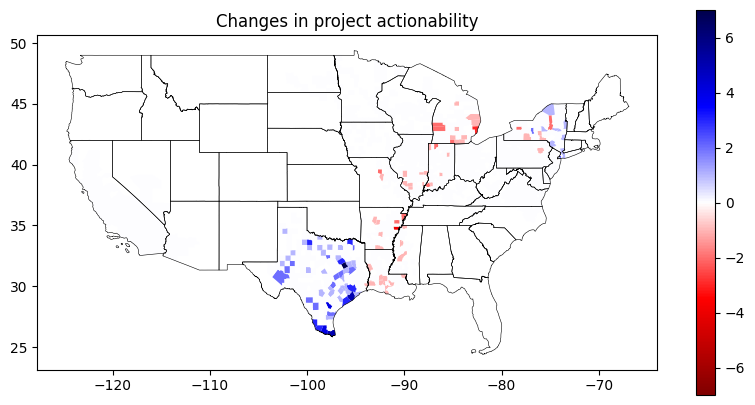

In [116]:
fig, ax = matplotlib.pyplot.subplots(figsize = (10,5))
ax.set_title("Changes in project actionability")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-7, vcenter=0, vmax=7) # Force 0 to be center of scale
base = agg_actionable.plot(ax = ax, column="actionability_change", cmap = "seismic_r", norm=divnorm, legend = True)
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

<Axes: title={'center': 'Changes in project certainty'}>

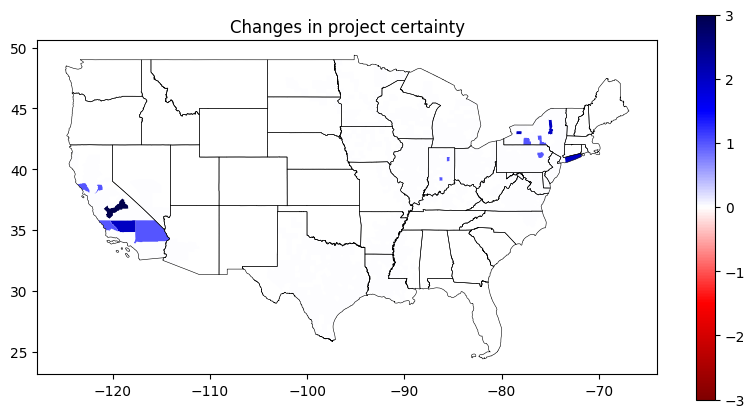

In [112]:
fig, ax = matplotlib.pyplot.subplots(figsize = (10,5))
ax.set_title("Changes in project certainty")
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3) # Force 0 to be center of scale
base = agg_actionable.plot(ax = ax, column="certainty_change", cmap = "seismic_r", norm=divnorm, legend = True)
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)

In [133]:
changes_sp['project_date_change'] = changes_sp['proposed_completion_date_y'] - changes_sp['proposed_completion_date_x']
date_change = changes_sp.loc[changes_sp.project_date_change.notnull(), ['project_date_change', 'geometry', 'county_id_fips']]
agg_date_change = date_change.dissolve(by='county_id_fips', aggfunc='mean')

<Axes: title={'center': 'Changes in project certainty'}>

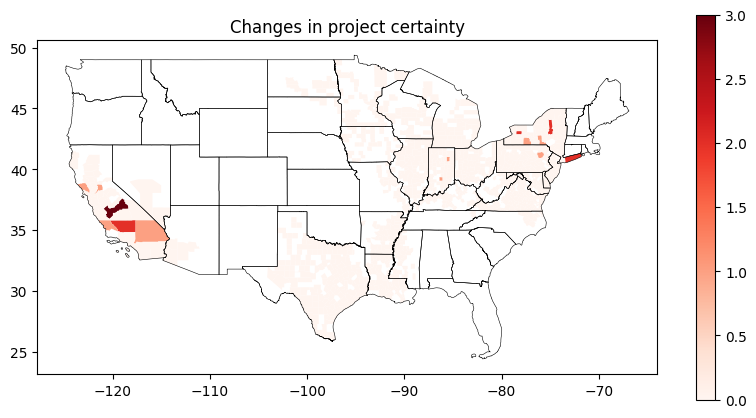

In [135]:
fig, ax = matplotlib.pyplot.subplots(figsize = (10,5))
ax.set_title("Changes in project certainty")
base = agg_actionable.plot(ax = ax, column="certainty_change", cmap = "Reds", legend = True)
state_plot.boundary.plot(ax = ax, edgecolor="black", linewidth = 0.4)